## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = f = open("data/complaints-2021-05-14_08_16.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
# Inspect the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [5]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [6]:
df.shape

(78313, 22)

In [7]:
#Assign new column names
#Removing _source from column name
df_columns = df.columns
new_column_names = [ column.replace("_source.","") for column in df_columns]
df.columns = new_column_names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _index                     78313 non-null  object 
 1   _type                      78313 non-null  object 
 2   _id                        78313 non-null  object 
 3   _score                     78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [8]:
#Checking the null values 
df.isnull().sum()

_index                           0
_type                            0
_id                              0
_score                           0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_what_happened          0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [9]:
print("Number of empty string in complaint_what_happend :",(df["complaint_what_happened"]=='').sum())

Number of empty string in complaint_what_happend : 57241


In [10]:
#Assign nan in place of blanks in the complaints column
df["complaint_what_happened"] = df["complaint_what_happened"].apply(lambda x : pd.NA if len(x)==0 else x)
print("Number of empty string in complaint :",(df["complaint_what_happened"]=='').sum())

Number of empty string in complaint : 0


In [11]:
# Checking nan values in complaint column
print("Now nan values in complain column : ",df["complaint_what_happened"].isnull().sum())
df["complaint_what_happened"].isna().sum()

Now nan values in complain column :  57241


57241

In [12]:
#Remove all rows where complaints column is nan
df=df[~df["complaint_what_happened"].isna()]
print("Now nan values in complain column : ",df["complaint_what_happened"].isna().sum())

Now nan values in complain column :  0


In [13]:
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [14]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text) :
  text = text.lower() # Make the text lowercase
  text = re.sub(r'\[.*?\]', '', text) # Remove text in square brackets
  text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
  text = re.sub(r'\b\w*\d\w*\b', '', text)  #Remove words containing numbers
  return text;

In [15]:
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(clean_text))

In [19]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [17]:
#Write your function to Lemmatize the texts
def lemmmatize_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [18]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lemmmatize_text)

In [20]:
df_clean

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...
...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...


In [22]:
# Import Textblob for extracting noun phrases
!pip install textblob
from textblob import TextBlob

In [23]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [24]:
#Write your function to extract the POS tags 

def pos_tag(text):
  # write your code here
  sent = []
  blob = TextBlob(text)
  sent = [word for (word,tag) in blob.tags if tag=='NN']
  return " ".join(sent)

In [25]:
df_clean["complaint_POS_removed"] =   df_clean['complaint_lemmatized'].apply(pos_tag) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"]

In [26]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




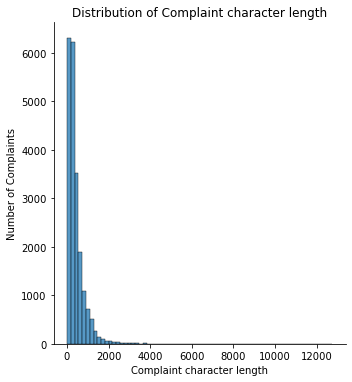

In [31]:
# Write your code here to visualise the data according to the 'Complaint' character length

character_length = [len(each_sent) for each_sent in df_clean['complaint_POS_removed']]

sns.displot(character_length, kind='hist', bins=70)
plt.xlabel("Complaint character length")
plt.ylabel("Number of Complaints")
plt.title("Distribution of Complaint character length")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [35]:
# Installing wordcloud
!pip install wordcloud

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [47]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

stopwords = set(STOPWORDS)
word_cloud = WordCloud(max_font_size=70, max_words=40, background_color="white", random_state=100, stopwords=stopwords)
word_cloud.generate(str(df_clean['complaint_POS_removed']))
plt.figure(figsize=[15,15])
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

OSError: cannot open resource

In [48]:
#Removing -PRON- from the text corpus 
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [49]:
df_clean.shape

(21072, 4)

In [50]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom xxxx prob...


#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [51]:
# Creating a function to extract top ngrams(unigram/bigram/trigram) based on the function inputs
def get_ngrams(text, n=None, ngram=(1,1)):
  vec = CountVectorizer(stop_words='english', ngram_range=ngram).fit(text)
  bagofwords = vec.transform(text)
  sum_words = bagofwords.sum(axis=0)
  words_frequency = [(word, sum_words[0, index]) for word, index in vec.vocabulary_.items()]
  words_frequency = sorted(words_frequency, key = lambda x: x[1], reverse=True)
  return words_frequency[:n]

In [52]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(1,1))
df_unigram = pd.DataFrame(top_30words, columns=['unigram', 'count'])
df_unigram

,unigram,count
0,account,47516
1,chase,46698
2,xxxx,36563
3,credit,34148
4,card,29278
5,bank,28402
6,payment,21165
7,time,16021
8,charge,14998
9,day,12972


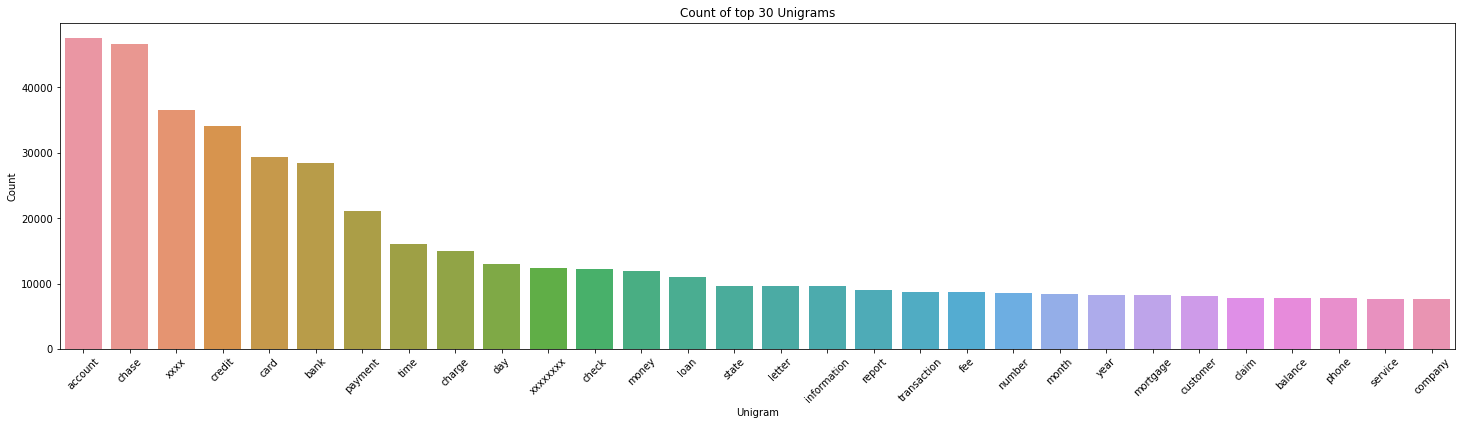

In [53]:
# Plotting top 30 Unigrams
plt.figure(figsize=[25,6])
sns.barplot(x=df_unigram['unigram'], y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [54]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47516
1,chase,46698
2,xxxx,36563
3,credit,34148
4,card,29278
5,bank,28402
6,payment,21165
7,time,16021
8,charge,14998
9,day,12972


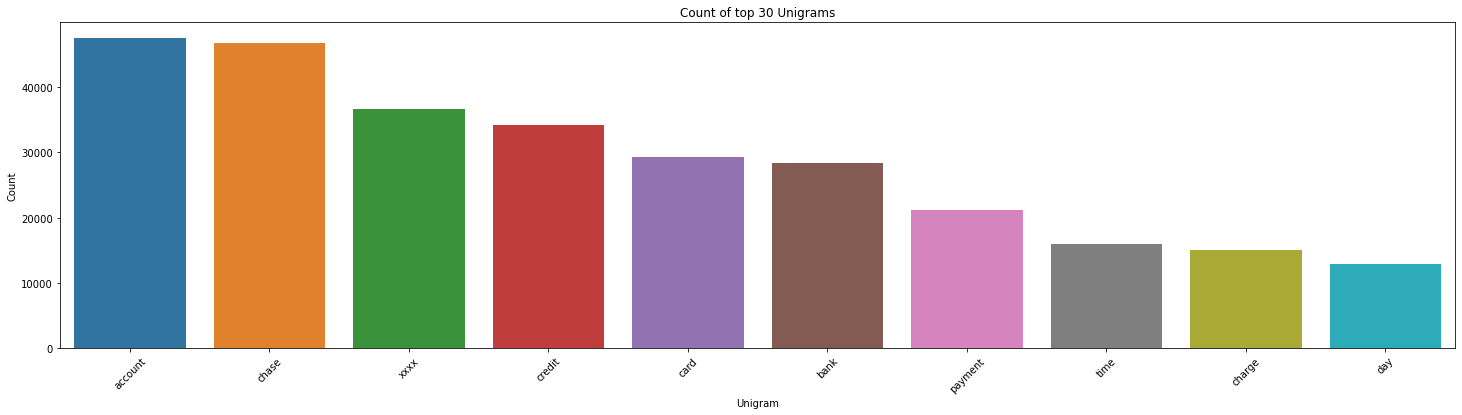

In [55]:
# Plotting top 10 words
plt.figure(figsize=[25,6])
sns.barplot(x=df_unigram['unigram'].head(10), y=df_unigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Unigram")
plt.ylabel("Count")
plt.title("Count of top 30 Unigrams")
plt.show()

In [56]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(2,2))
df_bigram = pd.DataFrame(top_30words, columns=['bigram', 'count'])
df_bigram

,bigram,count
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2939
6,bank account,2729
7,account chase,2595
8,chase account,2564
9,check account,2413


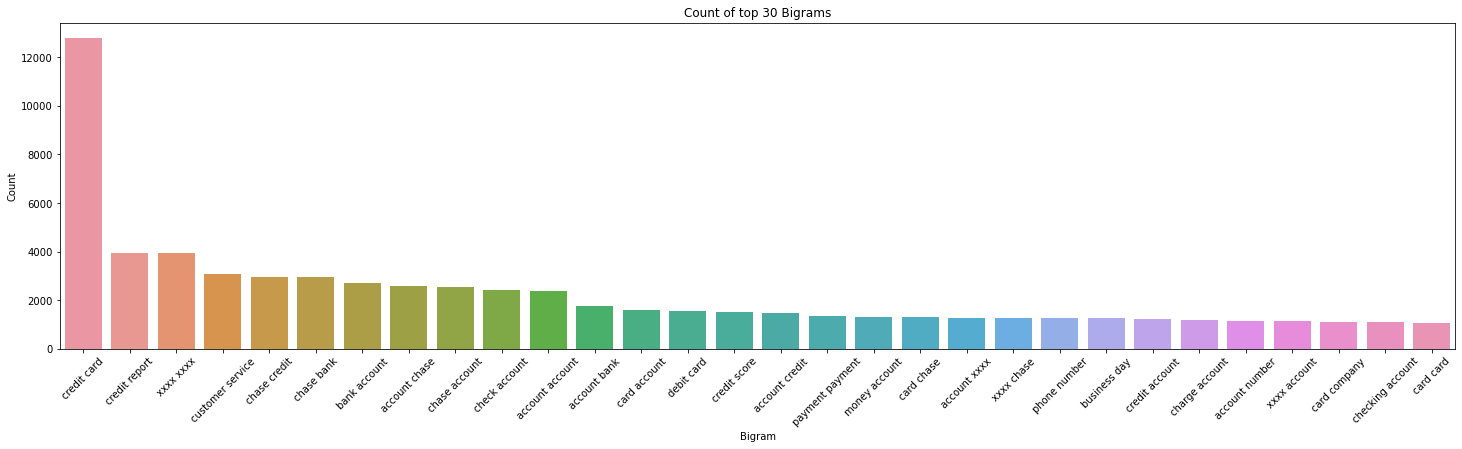

In [57]:
# Plotting top 30 Bigrams
plt.figure(figsize=[25,6])
sns.barplot(x=df_bigram['bigram'], y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 30 Bigrams")
plt.show()

In [58]:
#Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12778
1,credit report,3955
2,xxxx xxxx,3951
3,customer service,3081
4,chase credit,2966
5,chase bank,2939
6,bank account,2729
7,account chase,2595
8,chase account,2564
9,check account,2413


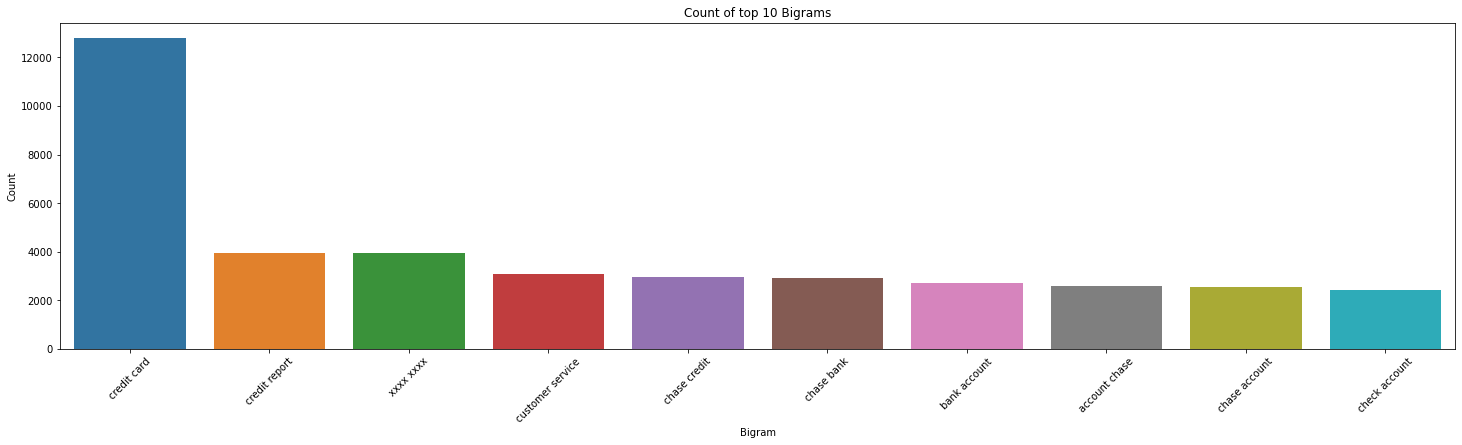

In [59]:
# Plotting top 10 Bugrams
plt.figure(figsize=[25,6])
sns.barplot(x=df_bigram['bigram'].head(10), y=df_bigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Bigram")
plt.ylabel("Count")
plt.title("Count of top 10 Bigrams")
plt.show()

In [60]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30words = get_ngrams(df_clean['Complaint_clean'].values.astype('U'), n=30, ngram=(3,3))
df_trigram = pd.DataFrame(top_30words, columns=['trigram', 'count'])
df_trigram

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


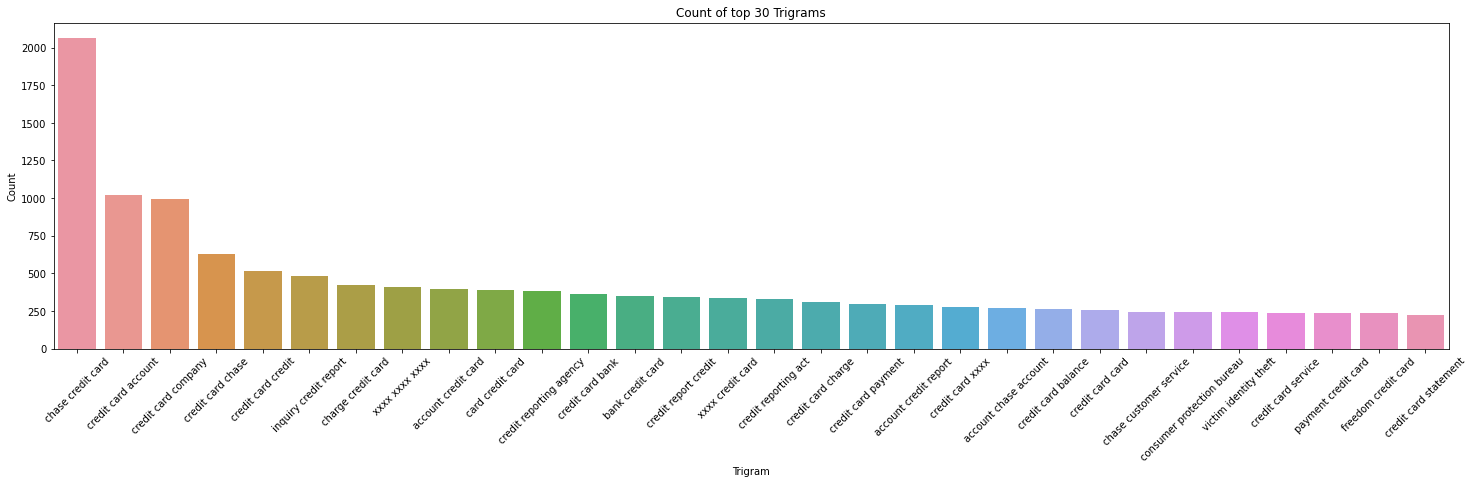

In [61]:
# Plotting top 30 Trigrams
plt.figure(figsize=[25,6])
sns.barplot(x=df_trigram['trigram'], y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 30 Trigrams")
plt.show()

In [62]:
#Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1022
2,credit card company,991
3,credit card chase,632
4,credit card credit,515
5,inquiry credit report,481
6,charge credit card,421
7,xxxx xxxx xxxx,411
8,account credit card,398
9,card credit card,388


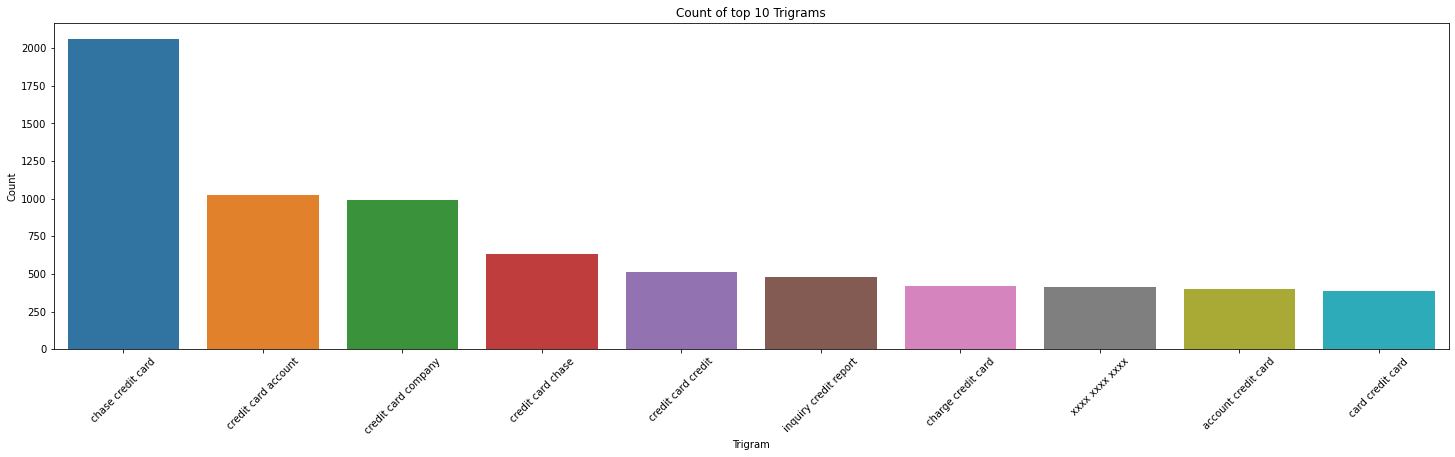

In [63]:
# Plotting top 10 Trigrams
plt.figure(figsize=[25,6])
sns.barplot(x=df_trigram['trigram'].head(10), y=df_trigram['count'])
plt.xticks(rotation=45)
plt.xlabel("Trigram")
plt.ylabel("Count")
plt.title("Count of top 10 Trigrams")
plt.show()

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [64]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [65]:
df_clean.shape

(21072, 4)

In [66]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [68]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [69]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
documet_term_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])

In [70]:
documet_term_matrix

<21072x7262 sparse matrix of type '<class 'numpy.float64'>'
	with 643554 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [71]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [72]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [73]:
nmf_model.fit(documet_term_matrix)
len(tfidf.get_feature_names_out())

C:\Users\HOME\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



7262

In [74]:
#Print the Top15 words for each of the topics
H = nmf_model.components_       # Topic-term matrix
words = np.array(tfidf.get_feature_names_out())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,check,bank,money,fund,chase,deposit,branch,day,number,business,transaction,claim,transfer,customer
Topic 2,credit,card,report,inquiry,chase,account,score,company,limit,information,debt,application,letter,year,balance
Topic 3,payment,balance,month,fee,statement,day,time,auto,date,pay,credit,account,chase,year,mortgage
Topic 4,charge,card,fee,transaction,dispute,chase,merchant,fraud,claim,purchase,service,time,statement,refund,company
Topic 5,loan,mortgage,home,modification,chase,property,year,letter,rate,time,document,bank,house,foreclosure,sale


**Observation** Looking at the topics above, for each topic, we can give a label based on their products/services:

Topic 1 = Bank account services

Topic 2 = Credit card / Prepaid card

Topic 3 = Others

Topic 4 = Theft/Dispute reporting

Topic 5 = Mortgages/loans

In [75]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(documet_term_matrix)

In [76]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] =  topic_results.argmax(axis=1)#write your code to assign topics to each rows.

In [77]:
df_clean.shape

(21072, 5)

In [78]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [79]:
#Print the first 5 Complaint for each of the Topics
df_clean_first_five=df_clean.groupby('Topic').head(5)
df_clean_first_five.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0
17,with out notice jp morgan chase restricted my ...,with out notice jp morgan chase restrict my ac...,jp chase account debit card tuesday thursday b...,jp chase account debit card tuesday thursday b...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,0
27,i opened an account with chase bank on xxxx an...,I open an account with chase bank on xxxx and ...,account bank code bonus term everything accoun...,account bank code bonus term everything accoun...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
15,can you please remove inquiry,can you please remove inquiry,inquiry,inquiry,1
23,i have a chase credit card which is incorrectl...,I have a chase credit card which be incorrectl...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,1


In [80]:
df_clean.shape

(21072, 5)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [81]:
#Create the dictionary of Topic names and Topics

topic_names = { 0:"Bank account services", 1:"Credit card / Prepaid card", 2:"Others",3:"Theft/Dispute reporting", 4:"Mortgages/loans"   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_names)

In [82]:
df_clean.shape

(21072, 5)

In [83]:
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,Bank account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,Credit card / Prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,Credit card / Prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,Credit card / Prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,Bank account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,card customer decade solicitation credit card ...,card customer decade solicitation credit card ...,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,on wednesday xxxxxxxx I call chas my xxxx xxxx...,visa credit card provider claim purchase prote...,visa credit card provider claim purchase prote...,Theft/Dispute reporting
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk provide consumer bank app chase year ...,pay risk provide consumer bank app chase year ...,Theft/Dispute reporting
78311,i have had flawless credit for yrs ive had ch...,I have have flawless credit for yrs I ve hav...,credit yrs credit card chase freedom xxxx prob...,credit yrs credit card chase freedom problem ...,Others


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [84]:
#Create the dictionary again of Topic names and Topics

topic_names = {  "Bank account services":0, "Credit card / Prepaid card":1, "Others":2, "Theft/Dispute reporting":3, "Mortgages/loans":4  }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(topic_names)

In [85]:
df_clean.shape

(21072, 5)

In [86]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,son chase account fund bank account pay money ...,0


In [87]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[['complaint_what_happened', 'Topic']]

In [88]:
training_data.shape

(21072, 2)

In [89]:
training_data

,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in and was told ...,1
10,chase card was reported on however fraudulent...,1
11,on while trying to book a xxxx xxxx ticket ...,1
14,my grand son give me check for i deposit it i...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,3
78311,i have had flawless credit for yrs ive had ch...,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
# Import pickle to save and load the model
#import pickle

In [90]:
#Write your code to get the Vector count
count_vectorizer = CountVectorizer()
X_train_cout = count_vectorizer.fit_transform(training_data['complaint_what_happened'])

In [91]:
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_cout)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

# Logistic regression : 

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [93]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data['Topic'], test_size=0.3, random_state=42)

In [94]:
X_train

<14750x33665 sparse matrix of type '<class 'numpy.float64'>'
	with 1587286 stored elements in Compressed Sparse Row format>

In [95]:
X_test

<6322x33665 sparse matrix of type '<class 'numpy.float64'>'
	with 693599 stored elements in Compressed Sparse Row format>

In [96]:
logistic_regression = LogisticRegression().fit(X_train, y_train)
predicted = logistic_regression.predict(X_test)

topicnames_target = ["Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans"]
print(classification_report(y_true=y_test, y_pred=predicted,target_names = topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.91      0.95      0.93      1582
Credit card / Prepaid card       0.92      0.93      0.93      1518
                    Others       0.95      0.88      0.91       671
   Theft/Dispute reporting       0.91      0.89      0.90      1450
           Mortgages/loans       0.93      0.93      0.93      1101

                  accuracy                           0.92      6322
                 macro avg       0.92      0.92      0.92      6322
              weighted avg       0.92      0.92      0.92      6322



C:\Users\HOME\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Decision Tree 

In [98]:
from sklearn.tree import DecisionTreeClassifier

In [101]:
# Decision tree classifier
decision_tree_classifier = DecisionTreeClassifier().fit(X_train, y_train)
predicted = decision_tree_classifier.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test, target_names = topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.78      0.81      0.79      1582
Credit card / Prepaid card       0.82      0.81      0.81      1518
                    Others       0.73      0.75      0.74       671
   Theft/Dispute reporting       0.74      0.73      0.74      1450
           Mortgages/loans       0.82      0.81      0.81      1101

                  accuracy                           0.78      6322
                 macro avg       0.78      0.78      0.78      6322
              weighted avg       0.78      0.78      0.78      6322



# Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [102]:
random_forest_classifier = RandomForestClassifier(max_depth=10)
random_forest_classifier.fit(X_train, y_train)
predicted = random_forest_classifier.predict(X_test)

print(classification_report(y_pred=predicted, y_true=y_test,target_names = topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.69      0.88      0.77      1582
Credit card / Prepaid card       0.63      0.86      0.73      1518
                    Others       1.00      0.01      0.01       671
   Theft/Dispute reporting       0.78      0.69      0.74      1450
           Mortgages/loans       0.85      0.72      0.78      1101

                  accuracy                           0.71      6322
                 macro avg       0.79      0.63      0.61      6322
              weighted avg       0.76      0.71      0.67      6322



# Naive Bayes (optional)

In [104]:
from sklearn.naive_bayes import GaussianNB

In [105]:
gaussian_navie_bayes = GaussianNB().fit(X_train.toarray(), y_train)
predicted = gaussian_navie_bayes.predict(X_test.toarray())

print(classification_report(y_pred=predicted, y_true=y_test,target_names = topicnames_target))

                            precision    recall  f1-score   support

     Bank account services       0.42      0.28      0.34      1582
Credit card / Prepaid card       0.38      0.31      0.34      1518
                    Others       0.15      0.44      0.23       671
   Theft/Dispute reporting       0.45      0.33      0.38      1450
           Mortgages/loans       0.48      0.47      0.47      1101

                  accuracy                           0.35      6322
                 macro avg       0.38      0.36      0.35      6322
              weighted avg       0.40      0.35      0.36      6322



# Observations :

1. Logistic regression : Accuracy is 0.92  , f1-scores are 0.93, 0.93, 0.91 ,0.90 and 0.93 for classess "Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans" respectively.

2. Decision Tree : Accuracy is 0.79  , f1-scores are 0.80, 0.81, 0.75, 0.74 and 0.82 for classess "Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans" respectively.

3. Random Forest : Accuracy is 0.72  , f1-scores are 0.79, 0.73, 0.06, 0.73 and 0.79  for classess "Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans" respectively.

4. Naive Bayes (optional) : Accuracy is 0.35  , f1-scores are 0.33,0.39, 0.23, 0.38 and 0.47 for classess "Bank account services", "Credit card / Prepaid card", "Others", "Theft/Dispute reporting", "Mortgages/loans" respectively.


From above analysis , we can see that Logistic regression is giving best accuracy and f1-scores.

# Using Logistic regression to predict ( some examples )

In [106]:
df_complaints = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "Yesterday, I received a fraudulent email regarding renewal of my services.",
                                  "What is the procedure to know my CIBIL score?",
                                  "I need to know the number of bank branches and their locations in the city of Dubai"]})
df_complaints

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,"Yesterday, I received a fraudulent email regar..."
4,What is the procedure to know my CIBIL score?
5,I need to know the number of bank branches and...


In [109]:
def predict_using_linear_regression(text):
    topic_names = {0:'Account Services', 1:'Others', 2:'Mortgage/Loan', 3:'Credit card or prepaid card', 4:'Theft/Dispute Reporting'}
    X_new_counts = count_vectorizer.transform(text)
    X_new_tfidf = tfidf_transformer.transform(X_new_counts)
    predicted = logistic_regression.predict(X_new_tfidf)
    return topic_names[predicted[0]]

In [110]:
df_complaints['tag'] = df_complaints['complaints'].apply(lambda x: predict_using_linear_regression([x]))
df_complaints

,complaints,tag
0,I can not get from chase who services my mortg...,Theft/Dispute Reporting
1,The bill amount of my credit card was debited ...,Others
2,I want to open a salary account at your downto...,Account Services
3,"Yesterday, I received a fraudulent email regar...",Credit card or prepaid card
4,What is the procedure to know my CIBIL score?,Others
5,I need to know the number of bank branches and...,Account Services
